## Double-Bracket Flow diagonalization algorithm

In this example we present the `Qibo`'s implementation of the Double-Bracket Flow (DBF) algorithm, which can be used to prepare the eigenstates of a quantum system. 

#### The initial setup

At first we import some useful packages.

In [43]:
from copy import deepcopy

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from hyperopt import hp, tpe

from qibo import hamiltonians, set_backend
from qibo.models.double_bracket import FlowGeneratorType, DoubleBracketFlow

Here we define a simple plotting function useful to keep track of the diagonalization process.

In [44]:
def visualize_matrix(matrix, title=""):
    """Visualize hamiltonian in a heatmap form."""
    fig, ax = plt.subplots(figsize=(5,5))
    ax.set_title(title)
    im = ax.imshow(np.absolute(matrix), cmap="inferno")
    fig.colorbar(im, ax=ax)

def visualize_drift(h0, h):
    """Visualize drift of the evolved hamiltonian w.r.t. h0."""
    fig, ax = plt.subplots(figsize=(5,5))
    ax.set_title(r"Drift: $|\hat{H}_0 - \hat{H}_{\ell}|$")
    im = ax.imshow(np.absolute(h0 - h), cmap="inferno")
    fig.colorbar(im, ax=ax)

def plot_histories(histories, labels):
    """Plot off-diagonal norm histories over a sequential evolution."""
    colors = sns.color_palette("inferno", n_colors=len(histories)).as_hex()
    plt.figure(figsize=(5,5*6/8))
    for i, (h, l) in enumerate(zip(histories, labels)):
        plt.plot(h, lw=2, color=colors[i], label=l, marker='.')
    plt.legend()
    plt.xlabel("Iterations")
    plt.ylabel(r"$\| \sigma(\hat{H}) \|^2$")
    plt.title("Loss function histories")
    plt.grid(True)
    plt.show()

We need to define a target hamiltonian which we aim to diagonalize. As an example, we consider the Transverse Field Ising Model (TFIM):
$$ H_{\rm TFIM} = - \sum_{q=0}^{N}\bigl( Z_i Z_{i+1} + h X_i \bigr),$$
which is already implemented in `Qibo`. For this tutorial we set $N=6$ and $h=3$.

[Qibo 0.2.2|INFO|2023-11-13 20:02:07]: Using qibojit (numba) backend on /CPU:0


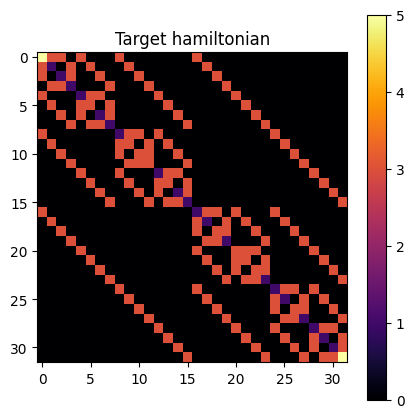

In [69]:
# set the qibo backend (we suggest qibojit if N >= 20)
set_backend("qibojit", "numba")

# define the hamiltonian
h = hamiltonians.TFIM(nqubits=5, h=3)

# vosualize the matrix
visualize_matrix(h.matrix, title="Target hamiltonian")

#### The generator of the evolution

The model is implemented following the procedure presented in [1], and the first practical step is to define the generator of the flow $\hat{\mathcal{U}}_{\ell}$, which executes one diagonalization step $$\hat{H}_{\ell} = \hat{\mathcal{U}}_{\ell}^{\dagger} \hat{H} \hat{\mathcal{U}}_{\ell}.$$ In `Qibo`, we define the flow type through a `FlowGeneratorType` object, which can be chosen between one of the following:
- `canonical`: the generator of the flow at step $k+1$ is defined using the commutator between the off diagonal part $\sigma(\hat{H_k})$ and the diagonal part $\Delta(\hat{H}_k)$ of the target evolved hamiltonian:
  $$\hat{\mathcal{U}}_{k+1}=\exp\bigl\{i[\Delta(\hat{H}_k), \sigma(\hat{H}_k)]\bigr\}.$$ 
- `single_commutator`: the evolution follows a similar procedure of the previous point in this list, but any additional matrix $D$ can be used to control the evolution:
    $$ \hat{\mathcal{U}}_{k+1}=\exp\bigl\{i[D, \hat{H}_k]\bigr\}. $$
- `group_commutator`: the following group commutator is used to compute the evolution:
  $$  \hat{\mathcal{U}}_{k+1}= e^{-isD} e^{is\hat{H}} e^{-isD} e^{-is\hat{H}}. $$

In order to set one of this evolution generators one can do as follow:

In [70]:
# we have a look inside the FlowGeneratorType class
for generator in FlowGeneratorType:
    print(generator)

FlowGeneratorType.canonical
FlowGeneratorType.single_commutator
FlowGeneratorType.group_commutator


In [71]:
# here we set the canonical generator
flowtype = FlowGeneratorType.canonical

#### The `DoubleBracketFlow` class

A `DoubleBracketFlow` object can be initialize by calling the `qibo.models.double_braket.DoubleBracketFlow` model and passing the target hamiltonian and the generator type we want to use to perform the evolutionary steps.

In [72]:
dbf = DoubleBracketFlow(hamiltonian=deepcopy(h), mode=flowtype)

#### `DoubleBracketFlow` features

In [73]:
# on which qibo backend am I running the algorithm?
print(f"Backend: {dbf.backend}")

Backend: qibojit (numba)


In [74]:
# the initial target hamiltonian is a qibo hamiltonian
# thus the matrix can be accessed typing h.matrix
print(f"Initial form of the target hamiltonian:\n{dbf.h0.matrix}")

Initial form of the target hamiltonian:
[[-5.-0.j -3.-0.j -3.-0.j ... -0.-0.j -0.-0.j -0.-0.j]
 [-3.-0.j -1.-0.j -0.-0.j ... -0.-0.j -0.-0.j -0.-0.j]
 [-3.-0.j -0.-0.j -1.-0.j ... -0.-0.j -0.-0.j -0.-0.j]
 ...
 [-0.-0.j -0.-0.j -0.-0.j ... -1.-0.j -0.-0.j -3.-0.j]
 [-0.-0.j -0.-0.j -0.-0.j ... -0.-0.j -1.-0.j -3.-0.j]
 [-0.-0.j -0.-0.j -0.-0.j ... -3.-0.j -3.-0.j -5.-0.j]]


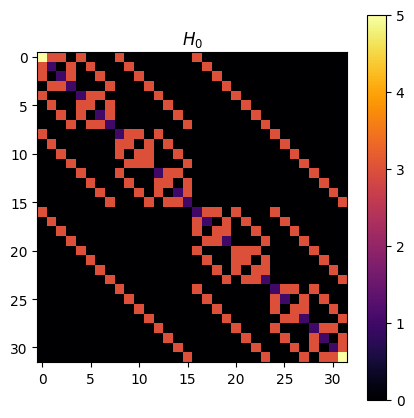

In [75]:
# let's visualize it in a more graphical way
visualize_matrix(dbf.h0.matrix, r"$H_0$")

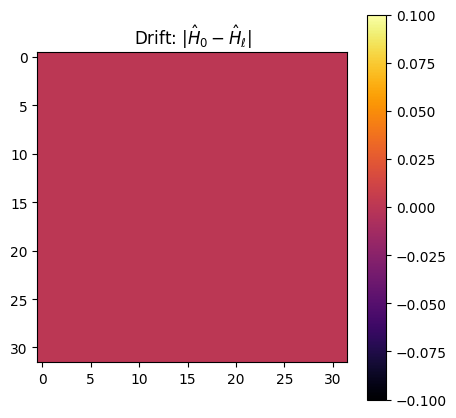

In [76]:
# since we didn't perform yet any evolutionary step they are the same
visualize_drift(dbf.h0.matrix, dbf.h.matrix)

which shows $\hat{H}$ is now identical to $\hat{H}_0$ since no evolution step has been performed yet.

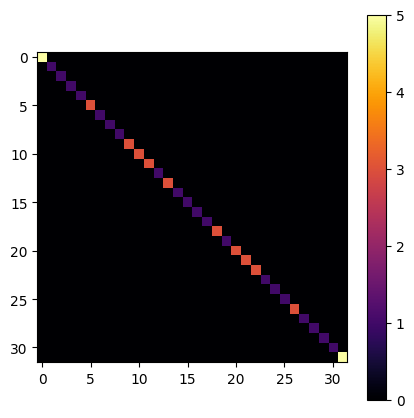

In [77]:
# diagonal part of the H target
visualize_matrix(dbf.diagonal_h_matrix)

In [78]:
# Hilbert-Schmidt norm of the off-diagonal part
# which we want to bring to be close to zero
print(f"HS norm of the off diagonal part of H: {dbf.off_diagonal_norm}")

HS norm of the off diagonal part of H: 1440.0


#### Call the `DoubleBracketFlow` to perform a DBF iteration

If the DBF object is called, a Double Bracket Flow iteration is performed. This can be done customizing the flow by setting the flow step and the desired `FlowGeneratorType`. If no generator is provided, the one passed at the initialization time is used (default is `FlowGeneratorType.canonical`).

In [79]:
# perform one evolution step

# initial value of the off-diagonal norm
print(f"Initial value of the off-diagonal norm: {dbf.off_diagonal_norm}")

dbf(step=0.01, mode=flowtype)

# after one step
print(f"One step later off-diagonal norm: {dbf.off_diagonal_norm}")

Initial value of the off-diagonal norm: 1440.0
One step later off-diagonal norm: 1168.2530943739996


We can check now if something happened by plotting the drift:

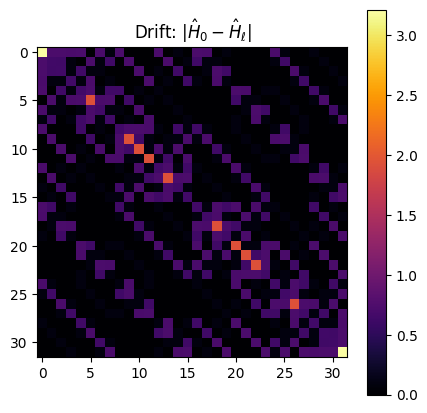

In [80]:
visualize_drift(dbf.h0.matrix, dbf.h.matrix)

The set step can be good, but maybe not the best one. In order to do this choice in a wiser way, we can call the DBF hyperoptimization routine to search for a better initial step. The `dbf.hyperopt_step` method is built on top of the [`hyperopt`](https://hyperopt.github.io/hyperopt/) package. Any algorithm or sampling space provided by the official package can be used. We are going to use the default options (we sample new steps from a uniform space following a _Tree of Parzen estimators algorithm_).

In [81]:
# restart
dbf.h = dbf.h0

# optimization of the step, we allow to search in [1e-5, 1]
step = dbf.hyperopt_step(
    step_min = 1e-5,
    step_max = 1,
    space = hp.uniform,
    optimizer = tpe,
    max_evals = 1000,
    verbose = True
)

100%|█████████████████████████████████████████████████████████████████████████| 1000/1000 [00:09<00:00, 100.75trial/s, best loss: 828.6241921617013]


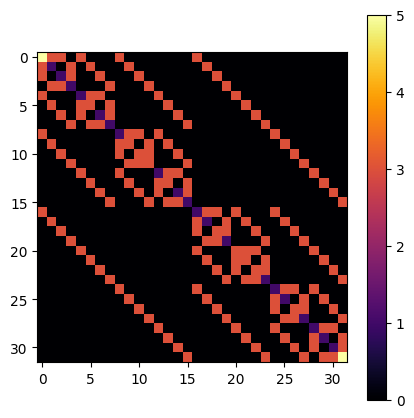

In [82]:
visualize_matrix(dbf.h.matrix)

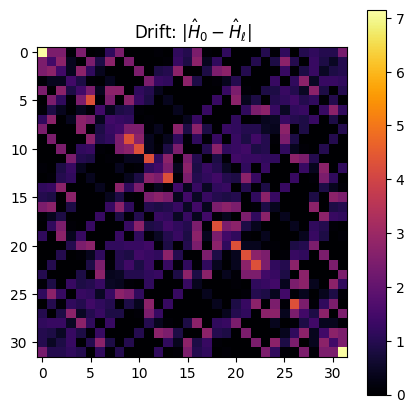

In [83]:
visualize_drift(dbf.h0.matrix, dbf.h.matrix)

#### Let's evolve the model for `NSTEPS`

We know recover the initial hamiltonian, and we perform a sequence of DBF iteration steps, in order to show how this mechanism can lead to a proper diagonalization of the target hamiltonian.

#### Method 1: fixed step

In [84]:
# restart
dbf_1 = DoubleBracketFlow(hamiltonian=deepcopy(h), mode=flowtype)
off_diagonal_norm_history = [dbf_1.off_diagonal_norm]
histories, labels = [], ["Fixed step"]

# set the number of evolution steps
NSTEPS = 20
step = 0.005

for s in range(NSTEPS):
    dbf_1(step=step)
    off_diagonal_norm_history.append(dbf_1.off_diagonal_norm)

histories.append(off_diagonal_norm_history)

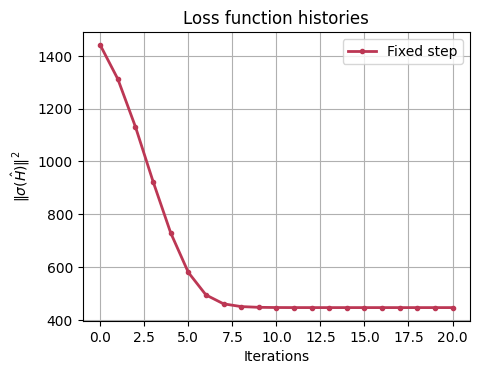

In [85]:
plot_histories(histories, labels)

#### Method 2: optimizing the step

In [86]:
# restart
dbf_2 = DoubleBracketFlow(hamiltonian=deepcopy(h), mode=flowtype)
off_diagonal_norm_history = [dbf_2.off_diagonal_norm]

# set the number of evolution steps
NSTEPS = 20

# optimize first step
step = dbf_2.hyperopt_step(
    step_min = 1e-5,
    step_max = 1,
    space = hp.uniform,
    optimizer = tpe,
    max_evals = 500,
    verbose = True 
)

for s in range(NSTEPS):
    if s != 0:
        step = dbf_2.hyperopt_step(
            step_min = 1e-5,
            step_max = 1,
            space = hp.uniform,
            optimizer = tpe,
            max_evals = 100, 
        )
        print(f"New optimized step: {step}")
    dbf_2(step=step)
    off_diagonal_norm_history.append(dbf_2.off_diagonal_norm)

histories.append(off_diagonal_norm_history)
labels.append("Optimizing step")

100%|███████████████████████████████████████████████████████████████████████████| 500/500 [00:03<00:00, 139.16trial/s, best loss: 829.4328971659771]
New optimized step: 0.011402705976672802
New optimized step: 0.006325014072323076
New optimized step: 0.010001573165578734
New optimized step: 0.007316716304573426
New optimized step: 0.0076802187698581095
New optimized step: 0.005495896033227967
New optimized step: 0.007264060988945372
New optimized step: 0.01135271597899832
New optimized step: 0.006630479573440658
New optimized step: 0.012085489806130539
New optimized step: 0.005846928182131419
New optimized step: 0.008295938853037754
New optimized step: 0.0004088170011721827
New optimized step: 0.00036462944225239616
New optimized step: 0.0010186195535541141
New optimized step: 0.008008841699702174
New optimized step: 0.0018840493701289263
New optimized step: 0.005885553634458635
New optimized step: 0.0026508328880453513


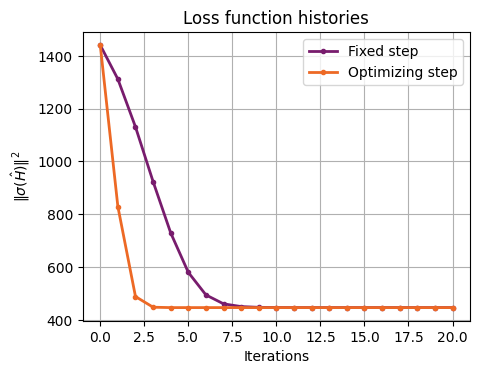

In [87]:
plot_histories(histories, labels)

The hyperoptimization can lead to a faster convergence of the algor

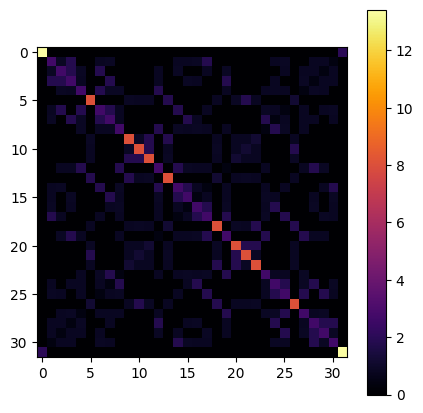

In [66]:
visualize_matrix(dbf_1.h.matrix)

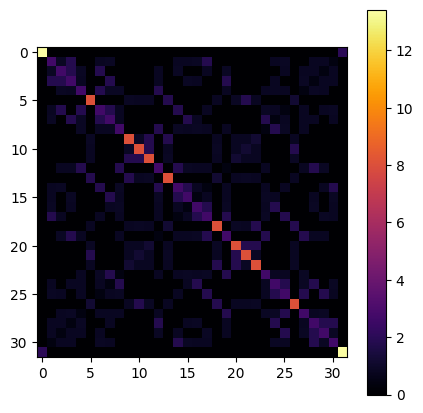

In [67]:
visualize_matrix(dbf_2.h.matrix)